In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

/home/han/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13832290441375646626
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6931565773
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8287642749152789543
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
num_classes = 10
epochs = 30
# input image dimensions
img_rows, img_cols = 28, 28

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
# normalize data to [0,...,1] rather than original [0,..., 255]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes) #(60000,10)
y_test = keras.utils.to_categorical(y_test, num_classes) #(10000,10)

In [7]:
# split x train into train and val
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 1)

In [8]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0],'validation samples')

x_train shape: (54000, 28, 28, 1)
54000 train samples
10000 test samples
6000 validation samples


In [9]:
model = Sequential()
# convolutional layer #1
model.add(Conv2D(32, kernel_size = (5, 5), padding = 'same',
                 activation = 'relu', input_shape = input_shape))
# convolutional layer #2
model.add(Conv2D(32, kernel_size = (5, 5), padding = 'same',
                 activation = 'relu'))
# pooling layer #1
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

# convolutional layer #3
model.add(Conv2D(64, kernel_size = (5, 5), padding = 'same',
                 activation='relu'))
# convolutional layer #4
model.add(Conv2D(64, kernel_size = (5, 5), padding = 'same',
                 activation='relu'))
# pooling layer #2
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25)) # tuning parameter

model.add(Flatten())
# dense layer #1
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))
# dense layer #2
model.add(Dense(num_classes, activation = 'softmax'))
# compile model
model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.Adadelta(),
              metrics = ['accuracy'])

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [11]:
# Data Augmentation on training dataset
    # randomly rotate some images 10 degrees
    # randomly shift some images horizontally 10% of the width
    # randomly shift some images vertically 10% of the height
    # randomly zoom some images 10%
    # randomly shear intensity 10%
gen = ImageDataGenerator(rotation_range=10, 
                         width_shift_range=0.1, 
                         height_shift_range=0.1,
                         shear_range = 0.1,
                         zoom_range=0.1)
train_generator = gen.flow(x_train, y_train, batch_size=64)
# don't apply data augmentation on validation set
val_gen = ImageDataGenerator()
val_generator = val_gen.flow(x_val, y_val, batch_size=64)

In [12]:
# Set a learning rate annealer
# reduce the learning rate by half if validation accuracy doesn't improve after 3 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [13]:
mymodel = model.fit_generator(train_generator, steps_per_epoch=60000//64, 
                              epochs=epochs, validation_data = val_generator,
                              callbacks=[learning_rate_reduction])

Epoch 1/30
937/937 [==============================] - 11s 12ms/step - loss: 0.2777 - acc: 0.9106 - val_loss: 0.0514 - val_acc: 0.9828
Epoch 2/30
937/937 [==============================] - 10s 10ms/step - loss: 0.0694 - acc: 0.9788 - val_loss: 0.0368 - val_acc: 0.9883
Epoch 3/30
937/937 [==============================] - 10s 10ms/step - loss: 0.0537 - acc: 0.9836 - val_loss: 0.0254 - val_acc: 0.9923
Epoch 4/30
937/937 [==============================] - 10s 10ms/step - loss: 0.0426 - acc: 0.9868 - val_loss: 0.0283 - val_acc: 0.9908
Epoch 5/30
937/937 [==============================] - 10s 10ms/step - loss: 0.0396 - acc: 0.9877 - val_loss: 0.0323 - val_acc: 0.9922
Epoch 6/30
937/937 [==============================] - 10s 10ms/step - loss: 0.0367 - acc: 0.9889 - val_loss: 0.0204 - val_acc: 0.9933
Epoch 7/30
937/937 [==============================] - 10s 10ms/step - loss: 0.0327 - acc: 0.9899 - val_loss: 0.0215 - val_acc: 0.9933
Epoch 8/30
937/937 [==============================] - 10s 10ms

In [14]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.01221737820001008
Test accuracy: 0.9968


In [15]:
# 99.35%  epch = 12 original kera example layer
# 99.47%  epoch = 30, 2*conv(32,5,5) + pooling(2,2)+dropout(0.25)+2*conv(64,5,5) + pooling(2,2)+dropout(0.25)+dense(1024)+dropout(0.5)+dense(10)
# 99.6%   + data augmentation + learning rate reduce (more than 7h on macbook pro)
# 99.68%  5min on a GTX1080 GPU (much much faster!!)

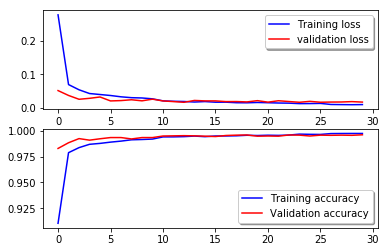

In [16]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(mymodel.history['loss'], color='b', label="Training loss")
ax[0].plot(mymodel.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(mymodel.history['acc'], color='b', label="Training accuracy")
ax[1].plot(mymodel.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)